In [ ]:
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import ipywidgets
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torchsummary import summary
from skimage import io
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import warnings
import random
import cv2
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Mar  5 23:50:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960    WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8    10W / 208W |   1854MiB /  4096MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torch.utils.data import Dataset , DataLoader

root_dir = r'D:\Deep_learning_Datasets\Kitti_RoadSegmentation'
train_dir = os.path.join(root_dir , 'training')

train_image, train_gt_image = [] , []

train_image_dir = os.path.join(train_dir , 'image_2')
train_image = os.listdir(train_image_dir)


train_gt_image_dir = os.path.join(train_dir , 'gt_image_2')
train_gt_image = os.listdir(train_gt_image_dir)


print(f'Total Images :  {len(train_image)}\nTotal GT Images: {len(train_gt_image)}')

Total Images :  289
Total GT Images: 384


In [ ]:
image_gt_image = []
for ele in train_image:
    li = ele.split('_')
    gt_image = '_'.join([li[0], 'road' , li[1]])
    if gt_image in train_gt_image:
        image_gt_image.append((ele, gt_image))
for i in range(3):
    print(image_gt_image[i])

('umm_000000.png', 'umm_road_000000.png')
('umm_000001.png', 'umm_road_000001.png')
('umm_000002.png', 'umm_road_000002.png')


In [ ]:
random.seed(10)
random.shuffle(image_gt_image)
train_igti = image_gt_image[:249]
test_igti  = image_gt_image[249:]

In [ ]:
class PrepareData(nn.Module):
    def __init__(self, image_name, image_root_dir , gt_image_root_dir, transform = None):
        self.transform = transform
        self.image_name = image_name
        self.image_root_dir = image_root_dir
        self.gt_image_root_dir = gt_image_root_dir

    def __len__(self):
        return len(self.image_name)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_path = os.path.join(self.image_root_dir , self.image_name[idx][0])
        image = io.imread(image_path) / 255.0

        gt_image_path = os.path.join(self.gt_image_root_dir , self.image_name[idx][1])
        gt_image = io.imread(gt_image_path)

        road_label  = np.array([255, 0, 255])
        road_mask = np.all(gt_image == road_label , axis = 2)

        if self.transform:
            image = self.transform(image)
            road_mask = self.transform(road_mask)

        return image , road_mask

In [ ]:
batch_size = 8
num_worker = 0

data_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((224,224)),
                                    ])

train_loader = DataLoader(PrepareData(image_name = train_igti,
                                     image_root_dir = train_image_dir,
                                      gt_image_root_dir = train_gt_image_dir,
                                     transform = data_transform),
                         batch_size = batch_size,
                         num_workers = num_worker,
                         shuffle = True
                         )

test_loader = DataLoader(PrepareData(image_name = test_igti,
                                    image_root_dir = train_image_dir,
                                    gt_image_root_dir = train_gt_image_dir,
                                    transform = data_transform),
                        batch_size = batch_size,
                        num_workers  = num_worker,
                        shuffle = False)
print('Num Training Images:' , len(train_loader))
print('Num Testing Images : ', len(test_loader))

Num Training Images: 32
Num Testing Images :  5


In [ ]:
def show(image_li):
    plt.figure(figsize = (18,18))
    title = ['Input Image' , 'True Mask' , 'Predicted Mask']

    for i in range(len(image_li)):
        plt.subplot(1, len(image_li) , i+1)
        plt.title(title[i])
        plt.imshow(image_li[i])
        plt.axis('off')
    plt.show()

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


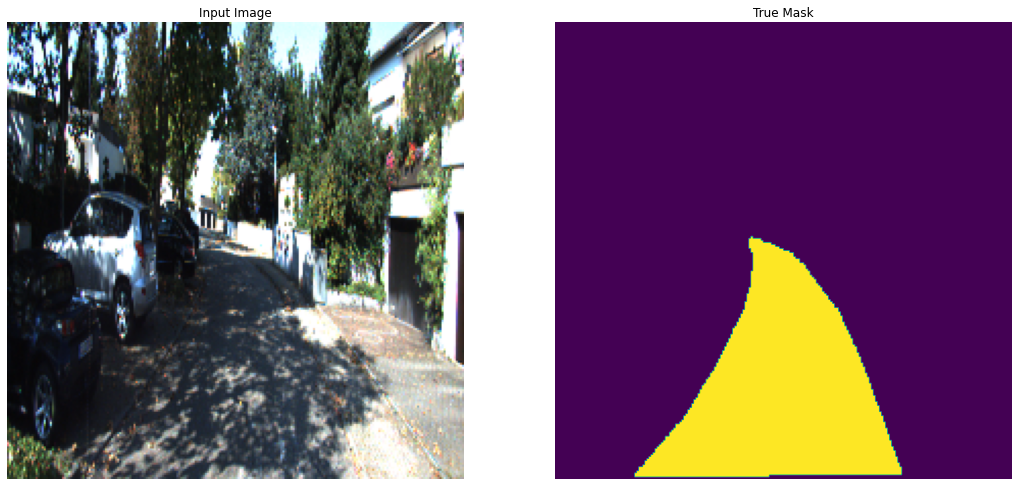

In [ ]:
examples = enumerate(train_loader)
batch_idx , (data, target) = next(examples)
print(data.shape , target.shape)
show([data[0].permute(1,2,0) , target[0][0]])

In [ ]:
target_numpy = target.detach().cpu().numpy()
print(np.unique(target_numpy))

[False  True]


In [ ]:
vgg16_model = models.vgg16_bn(pretrained = True).features
print(vgg16_model)

In [ ]:
class FCNetworkVG16(nn.Module):
    def __init__(self , vgg_16):
        super(FCNetworkVG16, self).__init__()

        self.conv1 = vgg16_model[0]
        self.bn1   = vgg16_model[1]
        self.relu1 = vgg16_model[2]
        self.conv2 = vgg16_model[3]
        self.bn2   = vgg16_model[4]
        self.relu2 = vgg16_model[5]
        self.maxp1 = vgg16_model[6]

        self.conv3 = vgg16_model[7]
        self.bn3   = vgg16_model[8]
        self.relu3 = vgg16_model[9]
        self.conv4 = vgg16_model[10]
        self.bn4   = vgg16_model[11]
        self.relu4 = vgg16_model[12]
        self.maxp2 = vgg16_model[13]

        self.conv5 = vgg16_model[14]
        self.bn5   = vgg16_model[15]
        self.relu5 = vgg16_model[16]
        self.conv6 = vgg16_model[17]
        self.bn6   = vgg16_model[18]
        self.relu6 = vgg16_model[19]
        self.conv7 = vgg16_model[20]
        self.bn7   = vgg16_model[21]
        self.relu7 = vgg16_model[22]
        self.maxp3 = vgg16_model[23]

        self.conv8 = vgg16_model[24]
        self.bn8   = vgg16_model[25]
        self.relu8 = vgg16_model[26]
        self.conv9 = vgg16_model[27]
        self.bn9   = vgg16_model[28]
        self.relu9 = vgg16_model[29]
        self.conv10 = vgg16_model[30]
        self.bn10   = vgg16_model[31]
        self.relu10 = vgg16_model[32]
        self.maxp4 = vgg16_model[33]

        self.conv11 = vgg16_model[34]
        self.bn11   = vgg16_model[35]
        self.relu11 = vgg16_model[36]
        self.conv12 = vgg16_model[37]
        self.bn12   = vgg16_model[38]
        self.relu12 = vgg16_model[39]
        self.conv13 = vgg16_model[40]
        self.bn13   = vgg16_model[41]
        self.relu13 = vgg16_model[42]
        self.maxp5 = vgg16_model[43]

        self.u1 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.conv14 = nn.Conv2d(512 , 256 , kernel_size = 1 , stride = 1)
        self.sig1 = nn.Sigmoid()
        self.u2 = nn.Upsample(scale_factor = 2 , mode = 'bilinear')
        self.conv15 = nn.Conv2d(256 , 256 , kernel_size = 1 , stride = 1)
        self.sig2 = nn.Sigmoid()
        self.u3 = nn.Upsample(scale_factor = 8 , mode = 'bilinear')
        self.conv16 = nn.Conv2d(256 , 1 , kernel_size = 1 , stride = 1)
        self.sig3 = nn.Sigmoid()

    def forward(self , x):

        x = self.conv1(x)
        x = self.bn1(x)
        self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        self.relu2(x)
        x = self.maxp1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        self.relu3(x)
        x = self.conv4(x)
        x = self.bn4(x)
        self.relu4(x)
        x = self.maxp2(x)


        x = self.conv5(x)
        x = self.bn5(x)
        self.relu5(x)
        x = self.conv6(x)
        x = self.bn6(x)
        self.relu6(x)
        x = self.conv7(x)
        x = self.bn7(x)
        self.relu7(x)
        c1 = self.maxp3(x)

        x = self.conv8(c1)
        x = self.bn8(x)
        self.relu8(x)
        x = self.conv9(x)
        x = self.bn9(x)
        self.relu9(x)
        x = self.conv10(x)
        x = self.bn10(x)
        self.relu10(x)
        c2 = self.maxp4(x)


        x = self.conv11(c2)
        x = self.bn11(x)
        self.relu11(x)
        x = self.conv12(x)
        x = self.bn12(x)
        self.relu12(x)
        x = self.conv13(x)
        x = self.bn13(x)
        self.relu13(x)
        c3 = self.maxp5(x)


        d1 = self.u1(c3) + c2
        d1 = self.conv14(d1)
        d1 = self.sig1(d1)
        d2 = self.u2(d1) + c1
        d2 = self.conv15(d2)
        d2 = self.sig2(d2)
        d3 = self.u3(d2)
        d3 = self.conv16(d3)
        d3 = self.sig3(d3)


        return d3

In [ ]:
model = FCNetworkVG16(vgg16_model)
print(model)

FCNetworkVG16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 25

In [ ]:
output = model.forward(data.float())
print(output.shape)

torch.Size([8, 1, 224, 224])


In [ ]:
import torch
from torch.autograd import Function

class DiceCoeff(Function):
    """Dice coeff for individual examples"""

    def forward(self, input, target):
        self.save_for_backward(input, target)
        eps = 1e-6
        target = target.float()
        self.inter = torch.dot(input.view(-1), target.view(-1))
        self.union = torch.sum(input) + torch.sum(target) + eps

        t = (2 * self.inter.float() + eps) / self.union.float()
        return t

    # This function has only a single output, so it gets only one gradient
    def backward(self, grad_output):

        input, target = self.saved_variables
        grad_input = grad_target = None

        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union - self.inter) \
                         / (self.union * self.union)
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(input, target):
    """Dice coeff for batches"""
    if input.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()

    for i, c in enumerate(zip(input, target)):
        s = s + DiceCoeff().forward(c[0], c[1])

    return -s / (i + 1)


In [ ]:
def iou_pytorch(outputs, targets , epsilon):
    outputs = outputs.int()
    targets = targets.int()
    outputs = outputs.squeeze(1)
    intersection = (outputs & targets).float().sum((1,2))
    union = (outputs | targets).float().sum((1,2))
    iou = (intersection + epsilon) / (union + epsilon)
    thresholded = torch.clamp(20*(iou-0.5) , 0 , 10).ceil() / 10
    return torch.mean(thresholded)

In [ ]:
print(dice_coeff(output , target))
loss = dice_coeff(output , target)
print(loss.item())

tensor([-0.2855], grad_fn=<DivBackward0>)
-0.28549888730049133


In [ ]:
import torch.optim as optim
model = model.cuda()
criterion = nn.BCELoss()
criterion = criterion.cuda()
# optimizer = optim.Adam(model.parameters(), lr = 1e-3)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9 , weight_decay = 2e-4)

In [ ]:
def train():

    train_loss_list = []
    train_iou_list = []
    test_loss_list = []
    test_iou_list = []
    best_loss = float('Inf')
    print('Training Started')
    count = 0

    for i in range(200):
        total_loss = 0
        train_iou_mean = 0
        model.train()
        for data, target in train_loader:
            data , target = Variable(data.cuda().float()), Variable(target.cuda())
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.float())
            total_loss+=loss.item()
            train_iou_mean+= iou_pytorch(output.detach(),target.detach() , 1e-7)
            loss.backward()
            optimizer.step()

        test_loss = 0
        test_iou_mean = 0

        model.eval()
        with torch.no_grad():
            for data, target in test_loader:
                data, target = Variable(data.cuda().float()), Variable(target.cuda())
                output = model(data)
                loss = criterion(output, target.float())
                test_loss+=loss.item()
                test_iou_mean+= iou_pytorch(output.detach(),target.detach(), 1e-7)

        if best_loss > test_loss:
            torch.save(model, r'D:\Deep_learning_Datasets\Kitti_RoadSegmentation\rs.pth')
            best_loss = test_loss
            print('New Best Epoch {}'.format(i+1))
            count = 0
        else:
            count +=1

        train_loss_list.append(total_loss/len(train_loader))
        train_iou_list.append(train_iou_mean / len(train_loader))
        test_loss_list.append(test_loss/ len(test_loader))
        test_iou_list.append(test_iou_mean / len(test_loader))
        print('Epoch {} - \nTrain loss : {}'.format(i+1 , total_loss/len(train_loader)))
        print('Test loss : {}'.format(test_loss/ len(test_loader)))
        print('Train IOU Mean : {}'.format(train_iou_mean / len(train_loader)))
        print('Test IOU Mean : {}'.format(test_iou_mean / len(test_loader)))
        print('Patience : {}'.format(15-count))
        print('------------------------------------------------------------------------')

        if count == 15:
            break

    return [train_loss_list, train_iou_list, test_loss_list, test_iou_list]

In [ ]:
!nvidia-smi

Sat Mar  5 21:49:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.89       Driver Version: 460.89       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 960    WDDM  | 00000000:01:00.0  On |                  N/A |
| 44%   44C    P2    26W / 208W |   1051MiB /  4096MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
history = train()

Training Started
New Best Epoch 1
Epoch 1 - 
Train loss : 0.7719447556883097
Test loss : 0.6446707606315613
Train IOU Mean : 0.3573172688484192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 2
Epoch 2 - 
Train loss : 0.5769688654690981
Test loss : 0.5186202764511109
Train IOU Mean : 0.3585379421710968
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 3
Epoch 3 - 
Train loss : 0.5051691196858883
Test loss : 0.4789090812206268
Train IOU Mean : 0.3635428249835968
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 4
Epoch 4 - 
Train loss : 0.48383552115410566
Test loss : 0.46457149386405944
Train IOU Mean : 0.3602469861507416
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------

New Best Epoch 35
Epoch 35 - 
Train loss : 0.4689056007191539
Test loss : 0.4523946404457092
Train IOU Mean : 0.3645194470882416
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 36
Epoch 36 - 
Train loss : 0.4702653093263507
Test loss : 0.45229493379592894
Train IOU Mean : 0.3598807752132416
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 37
Epoch 37 - 
Train loss : 0.47581443656235933
Test loss : 0.4522909164428711
Train IOU Mean : 0.3477957844734192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
Epoch 38 - 
Train loss : 0.47484778612852097
Test loss : 0.45235697627067567
Train IOU Mean : 0.3560965359210968
Test IOU Mean : 0.39921876788139343
Patience : 14
------------------------------------------------------------------------
Epoch 

Epoch 69 - 
Train loss : 0.46815745159983635
Test loss : 0.451873779296875
Train IOU Mean : 0.3643973469734192
Test IOU Mean : 0.39921876788139343
Patience : 9
------------------------------------------------------------------------
New Best Epoch 70
Epoch 70 - 
Train loss : 0.4712092261761427
Test loss : 0.45181320905685424
Train IOU Mean : 0.3573172390460968
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 71
Epoch 71 - 
Train loss : 0.4713292298838496
Test loss : 0.4517527997493744
Train IOU Mean : 0.3567069172859192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
Epoch 72 - 
Train loss : 0.47147705499082804
Test loss : 0.45178416967391966
Train IOU Mean : 0.3573172688484192
Test IOU Mean : 0.39921876788139343
Patience : 14
------------------------------------------------------------------------
New Best Epoch 73
Epoch 73

New Best Epoch 103
Epoch 103 - 
Train loss : 0.47200136072933674
Test loss : 0.45130881667137146
Train IOU Mean : 0.3567068874835968
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 104
Epoch 104 - 
Train loss : 0.47234592866152525
Test loss : 0.4513042509555817
Train IOU Mean : 0.3530448079109192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 105
Epoch 105 - 
Train loss : 0.47159306332468987
Test loss : 0.4512917876243591
Train IOU Mean : 0.3557302951812744
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 106
Epoch 106 - 
Train loss : 0.46917444188147783
Test loss : 0.45126309990882874
Train IOU Mean : 0.3592703938484192
Test IOU Mean : 0.39921876788139343
Patience : 15
---------------------------------------------------

Epoch 137 - 
Train loss : 0.4699575062841177
Test loss : 0.4508523404598236
Train IOU Mean : 0.35731732845306396
Test IOU Mean : 0.39921876788139343
Patience : 14
------------------------------------------------------------------------
New Best Epoch 138
Epoch 138 - 
Train loss : 0.46825807448476553
Test loss : 0.4507564902305603
Train IOU Mean : 0.3608573079109192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 139
Epoch 139 - 
Train loss : 0.46822919975966215
Test loss : 0.4507091879844666
Train IOU Mean : 0.3608573377132416
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------
New Best Epoch 140
Epoch 140 - 
Train loss : 0.47016460448503494
Test loss : 0.4506945192813873
Train IOU Mean : 0.3563407063484192
Test IOU Mean : 0.39921876788139343
Patience : 15
------------------------------------------------------------------------

RuntimeError: CUDA error: the launch timed out and was terminated
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
model = torch.load(r'D:\Deep_learning_Datasets\Kitti_RoadSegmentation\rs.pth')
model.eval()

FCNetworkVG16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace=True)
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 25

In [ ]:
def weighted_img(img, initial_img, α=1., β=0.5, γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [ ]:
def process_image(image):
    image = cv2.resize(image, (224,224))
    pred_mask = model(torch.tensor(image).reshape(1,3,224,224).cuda().float())
    pred_mask = pred_mask.cpu().detach().numpy()
    mask = np.round_(pred_mask[0])

    zero_image = np.zeros_like(mask)
    mask = np.dstack((mask, zero_image, zero_image)) * 255
    mask = np.asarray(mask, np.uint8).reshape(224,224,3)

    final_image = weighted_img(mask, image)
    final_image = cv2.resize(final_image, (1280, 720))

    return final_image

In [ ]:
os.mkdir("videos")

In [ ]:
original_video = cv2.VideoCapture(r'D:\Deep_learning_Datasets\Kitti_RoadSegmentation\testing\project_video.mp4')
frame_width = int(original_video.get(3))
frame_height = int(original_video.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
fps = 60
output = cv2.VideoWriter("videos/" + 'project_video.mp4', fourcc, fps, (frame_width,frame_height))

# Process Video
while(original_video.isOpened()):
    ret, frame = original_video.read()

    if ret == True:
        # Write the frame into the file 'output.avi'
        output.write(process_image(frame))
    else:
        break

# When everything done, release the video capture and video write objects
original_video.release()
output.release()

In [ ]:
test_data = PrepareData(image_name = test_igti,
                                    image_root_dir = train_image_dir,
                                    gt_image_root_dir = train_gt_image_dir,
                                    transform = data_transform)

In [ ]:
image , mask = test_data.__getitem__(0)
image = torch.unsqueeze(image , 0)
pred_mask = model(image.cuda().float())
pred_mask = torch.squeeze(pred_mask , 0)
print(pred_mask)

tensor([[[0.1768, 0.1768, 0.1768,  ..., 0.1739, 0.1739, 0.1739],
         [0.1768, 0.1768, 0.1768,  ..., 0.1739, 0.1739, 0.1739],
         [0.1768, 0.1768, 0.1768,  ..., 0.1739, 0.1739, 0.1739],
         ...,
         [0.1833, 0.1833, 0.1833,  ..., 0.1770, 0.1770, 0.1770],
         [0.1833, 0.1833, 0.1833,  ..., 0.1770, 0.1770, 0.1770],
         [0.1833, 0.1833, 0.1833,  ..., 0.1770, 0.1770, 0.1770]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


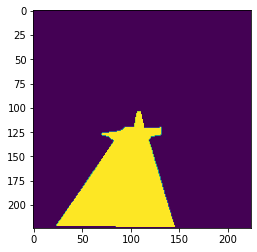

In [ ]:
plt.imshow(pred_mask.detach().cpu().numpy()[0])